In [1]:
%matplotlib nbagg
import os
import glob
from collections import defaultdict, namedtuple
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lsst.afw.table as afw_table
import lsst.daf.persistence as dp
import lsst.geom
import desc.sims_ci_pipe as scp

No module named 'lsst.sims'


In [2]:
def make_SourceCatalog(df):
    schema = afw_table.SourceTable.makeMinimalSchema()
    schema.addField('flux', type=float, doc='flux in nJy')
    src_cat = afw_table.SourceCatalog(schema)
    for iloc in range(len(df)):
        row = df.iloc[iloc]
        new_rec = src_cat.addNew()
        try:
            new_rec.set('id', int(row['id']))
        except ValueError:
            new_rec.set('id', iloc)
        new_rec.set('coord_ra', lsst.geom.Angle(row.ra, lsst.geom.degrees))
        new_rec.set('coord_dec', lsst.geom.Angle(row.dec, lsst.geom.degrees))
        new_rec.set('flux', row['flux'])
    return src_cat

In [3]:
def match_meas_fluxes(butler, visit, truth_df0,
                      flux_type='base_PsfFlux', max_offset=0.1,
                      point_sources=True):
    flux_col = f'{flux_type}_instFlux'
    radius = lsst.geom.Angle(max_offset, lsst.geom.arcseconds)
    dfs = []
    datarefs = butler.subset('src', visit=visit)
    for i, dataref in enumerate(list(datarefs)):
        try:
            calib = dataref.get('calexp').getPhotoCalib()
        except:
            continue
        src = dataref.get('src')
        if point_sources:
            src = scp.get_point_sources(src)
        ras = np.degrees(src.get('coord_ra'))
        decs = np.degrees(src.get('coord_dec'))
        ra_min, ra_max = min(ras), max(ras)
        dec_min, dec_max = min(decs), max(decs)
        query = f'{ra_min} <= ra <= {ra_max} and {dec_min} <= dec <= {dec_max}'
        truth_df = truth_df0.query(query)
        truth_cat = make_SourceCatalog(truth_df)

        matches = afw_table.matchRaDec(truth_cat, src, radius)
        num_matches = len(matches)
        print(i, len(truth_df), len(src), num_matches)
        ids = np.zeros(num_matches, dtype=np.int)
        offsets = np.zeros(num_matches, dtype=np.float)
        true_fluxes = np.zeros(num_matches, dtype=np.float)
        meas_fluxes = np.zeros(num_matches, dtype=np.float)
        meas_fluxerrs = np.zeros(num_matches, dtype=np.float)

        for i, match in enumerate(matches):
            ids[i] = match.first['id']
            offsets[i] = np.degrees(match.distance)*3600*1000.
            true_fluxes[i] = match.first['flux']
            meas_fluxes[i] = calib.instFluxToNanojansky(match.second[flux_col])
            meas_fluxerrs[i] \
                = calib.instFluxToNanojansky(match.second[flux_col + 'Err'])

        dfs.append(pd.DataFrame(data=dict(id=ids, offset=offsets,
                                          true_flux=true_fluxes,
                                          meas_flux=meas_fluxes,
                                          meas_fluxerr=meas_fluxerrs)))
    df = pd.concat(dfs)
    return df

In [4]:
def zeros():
    return dict(ra=0, dec=0, flux=0, npts=0)

def make_lens_sys_truth_cat(df, id_col='lens_sys_id'):
    data = defaultdict(zeros)
    for iloc in range(len(df)):
        row = df.iloc[iloc]
        record = data[row[id_col]]
        record['ra'] += row.ra
        record['dec'] += row.dec
        record['flux'] += row.flux
        record['npts'] += 1
    df_data = defaultdict(list)
    for obj_id in data:
        df_data['id'].append(obj_id)
        df_data['ra'].append(data[obj_id]['ra']/data[obj_id]['npts'])
        df_data['dec'].append(data[obj_id]['dec']/data[obj_id]['npts'])
        df_data['flux'].append(data[obj_id]['flux'])
    return pd.DataFrame(data=df_data)

In [5]:
#visit = 934713
#band = 'r'
visit = 906935
band = 'i'

In [6]:
df_stars = pd.read_pickle(f'src_truth_match_v{visit}-{band}.pkl')

In [7]:
df_stars.head()

,id,offset,true_flux,meas_flux,meas_fluxerr
0,1568442474,1.224634,71934.209695,72056.114241,373.181379
1,1568440891,8.698112,26452.118709,26099.044402,284.637346
2,1568440775,14.798808,13875.875437,13854.373064,256.139198
3,969636782,1.067295,432782.906116,427982.881430,777.837271
4,1247306401,4.286658,5119.827921,5196.184945,234.730805


<IPython.core.display.Javascript object>


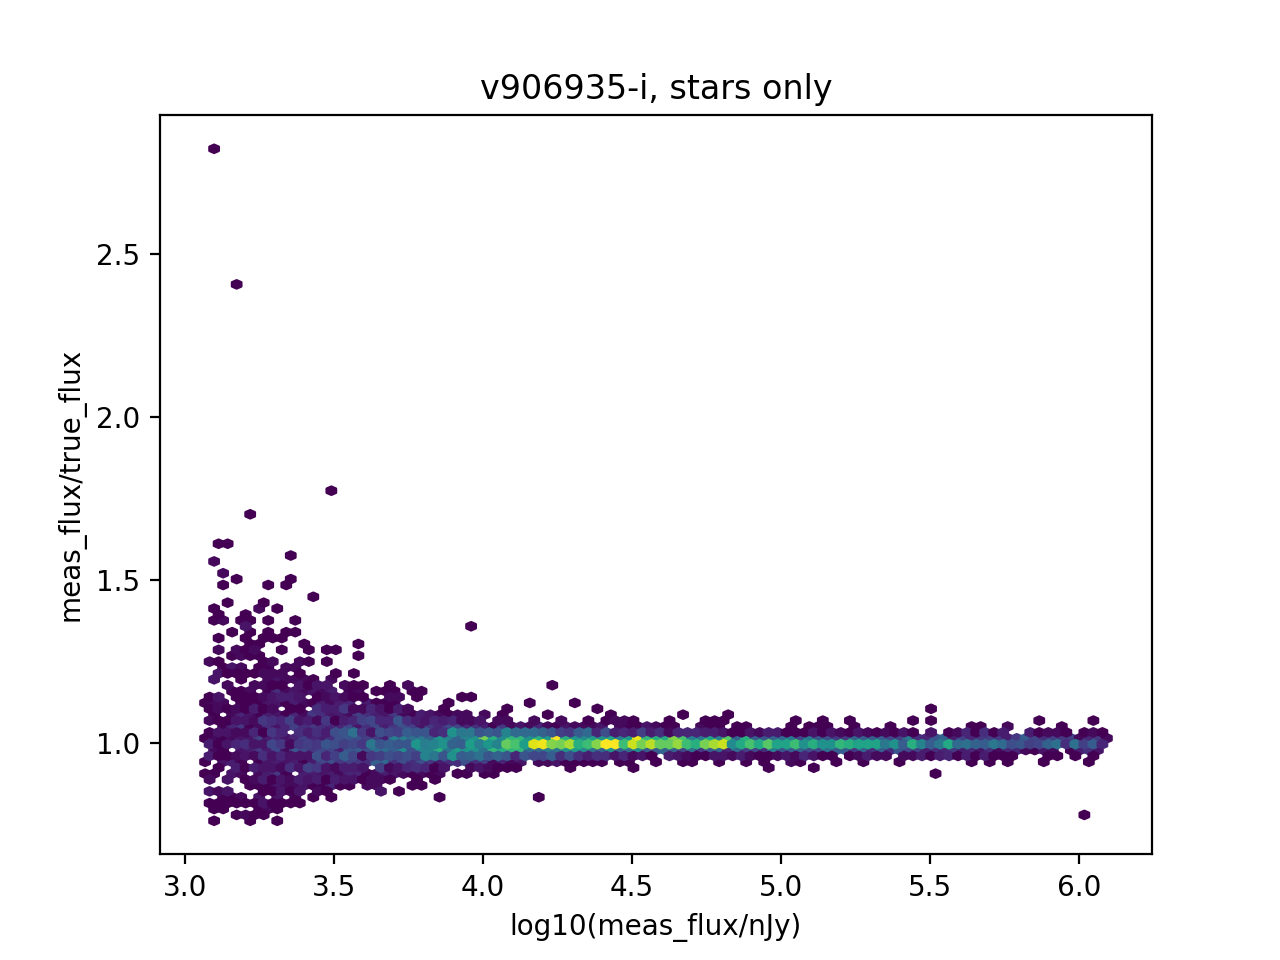

In [8]:
plt.figure()
plt.hexbin(np.log10(df_stars['meas_flux']), df_stars['meas_flux']/df_stars['true_flux'],
           mincnt=1)
plt.xlabel('log10(meas_flux/nJy)')
plt.ylabel('meas_flux/true_flux')
plt.title(f'v{visit}-{band}, stars only')
plt.savefig(f'v{visit}-{band}_flux_ratio_vs_meas_flux.png')

In [9]:
butler = dp.Butler('repo_agns')
truth_df0 = pd.read_pickle(f'agn_fluxes_v{visit}.pkl')
df_agns = match_meas_fluxes(butler, visit, truth_df0, max_offset=0.1)
print(len(df_agns))
print()

0 155 221 1
1 269 250 9
2 212 241 4
3 687 265 15
4 332 236 9
5 720 265 24
6 808 245 24
7 803 289 37
8 721 277 26
9 694 283 29
10 319 235 13
11 703 258 33
12 358 258 12
13 675 304 24
14 632 269 29
15 386 233 19
16 885 276 28
17 701 268 31
18 744 236 24
19 409 260 21
20 761 215 20
21 775 260 31
22 249 216 5
23 695 256 19
24 626 265 30
25 667 256 23
26 350 289 12
27 675 247 21
28 400 268 16
29 465 260 15
30 0 234 0
604



In [10]:
butler = dp.Butler('repo_lensed_agns')
truth_df0 = make_lens_sys_truth_cat(pd.read_pickle(f'lensed_agn_fluxes_v{visit}.pkl'))
df_lensed_agns = match_meas_fluxes(butler, visit, truth_df0, max_offset=0.1,
                                   flux_type='base_CircularApertureFlux_12_0', point_sources=False)
print(len(df_lensed_agns))
print()

0 8 335 0
1 23 425 0
2 20 413 0
3 57 462 3
4 30 589 0
5 65 462 1
6 69 434 1
7 72 452 4
8 61 415 0
9 77 470 0
10 23 386 1
11 67 424 2
12 36 389 1
13 69 964 1
14 75 469 2
15 44 400 2
16 70 522 2
17 71 506 4
18 72 382 2
19 24 414 0
20 97 404 3
21 86 474 1
22 37 354 0
23 79 485 0
24 67 434 2
25 81 468 2
26 38 786 0
27 76 438 6
28 37 514 1
29 54 412 0
30 0 381 0
41



In [11]:
butler = dp.Butler('repo_lensed_sne')
truth_df0 = make_lens_sys_truth_cat(pd.read_pickle(f'lensed_sne_fluxes_v{visit}.pkl'))
df_lensed_sne = match_meas_fluxes(butler, visit, truth_df0)
print(len(df_lensed_sne))
print()

0 14 220 0
1 20 243 0
2 14 237 0
3 64 249 0
4 28 227 0
5 72 238 0
6 82 221 0
7 66 250 0
8 60 253 0
9 79 241 0
10 23 219 0
11 65 230 0
12 34 241 0
13 84 276 0
14 91 239 0
15 40 215 0
16 70 241 0
17 52 226 0
18 65 199 0
19 31 242 0
20 76 205 0
21 63 220 0
22 38 202 0
23 77 244 0
24 80 226 0
25 64 238 0
26 25 276 0
27 92 224 0
28 55 253 0
29 54 236 0
30 0 234 0
0



In [12]:
butler = dp.Butler('repo_lensed_hosts')
truth_df0 = make_lens_sys_truth_cat(pd.read_pickle(f'host_fluxes_v{visit}.pkl'), id_col='id')
df_hosts = match_meas_fluxes(butler, visit, truth_df0, flux_type='base_CircularApertureFlux_12_0',
                             point_sources=False)
print(len(df_hosts))
print()

0 22 334 0
1 43 418 1
2 41 400 0
3 130 439 3
4 59 581 0
5 141 444 4
6 155 397 2
7 138 416 2
8 121 387 2
9 159 424 2
10 51 377 1
11 137 402 1
12 72 380 1
13 154 927 4
14 168 435 5
15 86 384 1
16 140 484 1
17 128 482 2
18 137 338 3
19 55 404 3
20 174 377 2
21 150 408 0
22 76 336 0
23 168 439 1
24 147 408 2
25 159 435 2
26 67 782 0
27 170 413 5
28 92 508 3
29 111 385 1
30 0 381 0
54



<IPython.core.display.Javascript object>


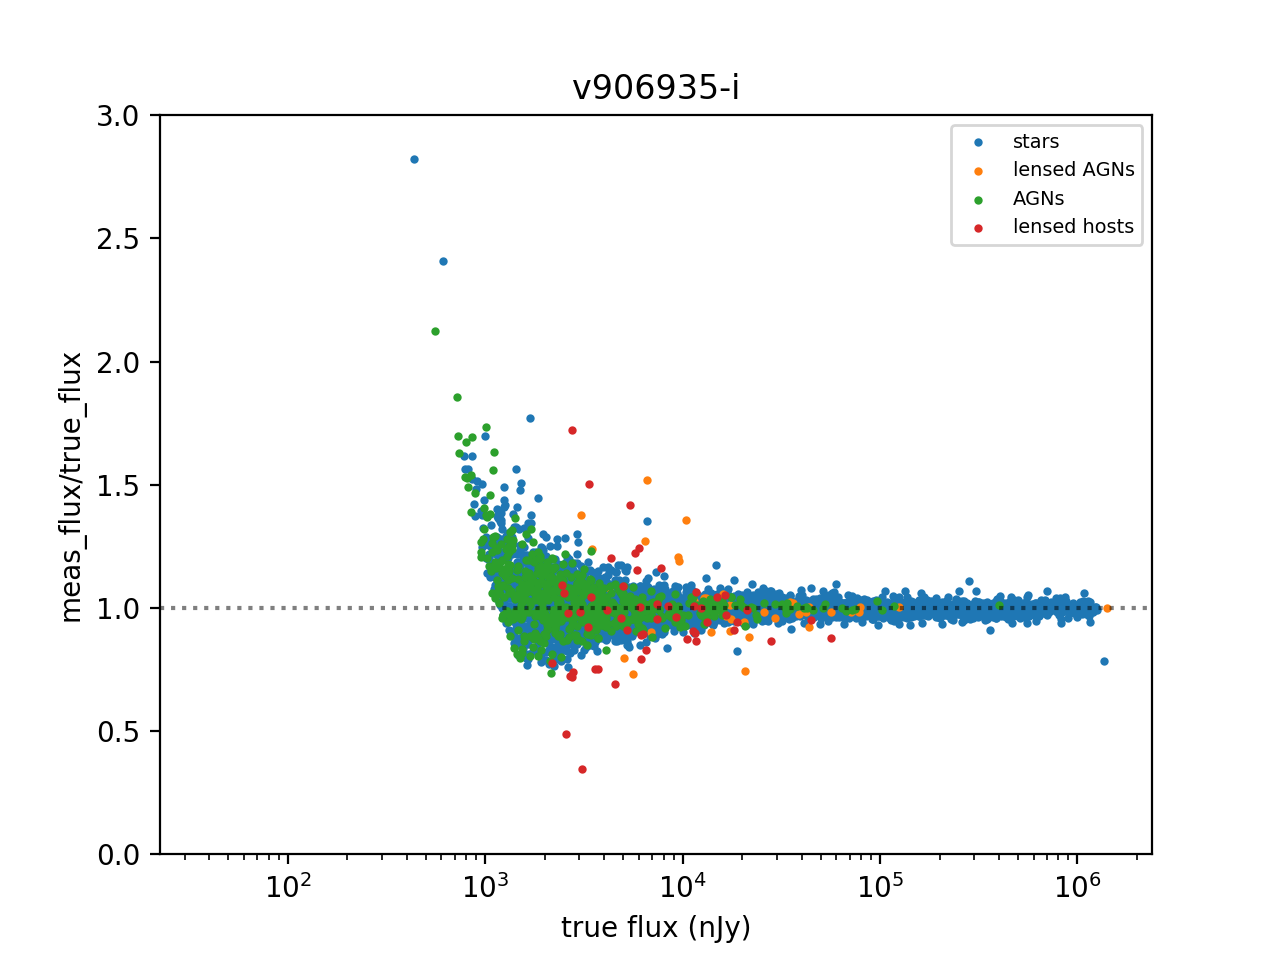

In [13]:
plt.figure()

plt.scatter(df_stars['true_flux'], df_stars['meas_flux']/df_stars['true_flux'], s=4, label='stars')
plt.scatter(df_lensed_agns['true_flux'], df_lensed_agns['meas_flux']/df_lensed_agns['true_flux'], s=4,
            label='lensed AGNs', alpha=1)
plt.scatter(df_agns['true_flux'], df_agns['meas_flux']/df_agns['true_flux'], s=4,
            label='AGNs', alpha=1)
#plt.scatter(df_lensed_sne['true_flux'], df_lensed_sne['meas_flux']/df_lensed_sne['true_flux'], s=4,
#            label='lensed SNe', alpha=1)
plt.scatter(df_hosts['true_flux'], df_hosts['meas_flux']/df_hosts['true_flux'], s=4,
            label='lensed hosts', alpha=1)
plt.xscale('log')
plt.axhline(1, linestyle=':', color='black', alpha=0.5)
plt.legend(fontsize='x-small')
plt.title(f'v{visit}-{band}')
plt.xlabel('true flux (nJy)')
plt.ylabel('meas_flux/true_flux')
plt.ylim(0, 3)
plt.savefig(f'Run3.0i_instcat_flux_checks_v{visit}-{band}.png')